In [254]:
!pip install -qU pandas numpy scikit-learn

# Постановка задачи:

1) <code>Бизнес задача</code>: Кредитный скоринг.
- <code>ml-задача</code>: многоклассовая классификация (три класса: good, poor, standard)
- <code>Данные</code>: в качестве набора данных будет использован dataset из kaggle <code>Credit score classification</code>.

2) <code>Метрика</code>: в качестве метрики оценивания будет выбран <code>Recall</code>. Модель должна стремиться обнаружить как можно больше потенциальных проблемных заемщиков. Пропустить рискованного клиента (низкий recall) может быть гораздо дороже для бизнеса, чем ошибочно отказать в кредите более надежному клиенту.

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# EDA

<code>Key Features</code>
Описания фичей:

- ID: Уникальный идентификатор для каждой записи в наборе данных.
- Customer_ID: Идентификатор для каждого клиента.
- Month: Месяц сбора данных.
- Name: Имя клиента.
- Age: Возраст клиента.
- SSN: Номер социального страхования клиента.
- Occupation: Профессия клиента.
- Annual_Income: Годовой доход клиента.
- Monthly_Inhand_Salary: Ежемесячная зарплата после вычетов.
- Num_Bank_Accounts: Количество банковских счетов у клиента.
- Num_Credit_Card: Количество кредитных карт у клиента.
- Interest_Rate: Процентная ставка по займам.
- Num_of_Loan: Количество займов у клиента.
- Type_of_Loan: Тип займа, взятого клиентом.
- Delay_from_due_date: Количество дней просрочки платежей.
- Num_of_Delayed_Payment: Количество просроченных платежей у клиента.
- Changed_Credit_Limit: Указывает, был ли изменён кредитный лимит.
- Num_Credit_Inquiries: Количество запросов на получение кредита, сделанных клиентом.
- Credit_Mix: Сочетание различных типов кредитных счетов у клиента.
- Outstanding_Debt: Сумма непогашенного долга.
- Credit_Utilization_Ratio: Соотношение использованного кредита к доступному.
- Credit_History_Age: Возраст кредитной истории.
- Payment_of_Min_Amount: Указывает, выплачена ли минимальная сумма.
- Total_EMI_per_month: Общая сумма ежемесячного платежа (EMI), выплачиваемая клиентом.
- Amount_invested_monthly: Сумма, инвестируемая клиентом ежемесячно.
- Payment_Behaviour: Платежное поведение клиента.
- Monthly_Balance: Ежемесячный баланс на счёте.
- Credit_Score: Целевая переменная — кредитный рейтинг клиента.

In [256]:
# посмотрим на данные
df = pd.read_csv('dataset/train.csv')

In [257]:
# Посмотрим наличие пустых значений в датасете 
missing_count = df.isnull().sum()
value_count = df.isnull().count()
missing_percentage = round(missing_count / value_count * 100, 2)
missing_df = pd.DataFrame({"count": missing_count, "percentage": missing_percentage})
missing_df

,count,percentage
ID,0,0.00
Customer_ID,0,0.00
Month,0,0.00
Name,9985,9.98
Age,0,0.00
SSN,0,0.00
Occupation,0,0.00
Annual_Income,0,0.00
Monthly_Inhand_Salary,15002,15.00
Num_Bank_Accounts,0,0.00


В df довольно много фичей, поэтому обработаем каждую фичу, и постараемся создать новую из имеющих старых. 

In [258]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


### Age
Избавимся от всех пользователей кому за 100 и от всех чей возраст отрицательный.

In [259]:
df['Age'].unique()

array(['23', '-500', '28_', ..., '4808_', '2263', '1342'], dtype=object)

Получим распределение пользователей попадающие в интервал <code>0 >= age <= 100</code>

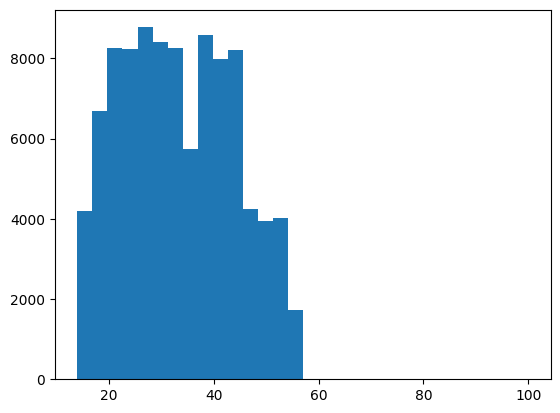

In [260]:
df['Age'] = df['Age'].apply(lambda x: x.replace('_','')).astype(int)                            
df = df.query("Age >= 0 and Age <= 100")
plt.hist(df['Age'], bins=30);

### Occupation

In [261]:
# посмотрим на все уникальные значения и при необходимости заменим на other
df['Occupation'].unique()

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [262]:
# все колиечство пользоватлелей для определенной доменной области
df['Occupation'] = df['Occupation'].apply(lambda x: x.replace('_______', 'other'))
df['Occupation'].value_counts()

Occupation
other            6873
Lawyer           6389
Architect        6175
Engineer         6172
Scientist        6113
Accountant       6110
Mechanic         6099
Media_Manager    6068
Teacher          6049
Developer        6031
Entrepreneur     6015
Doctor           5916
Journalist       5906
Manager          5807
Musician         5760
Writer           5741
Name: count, dtype: int64

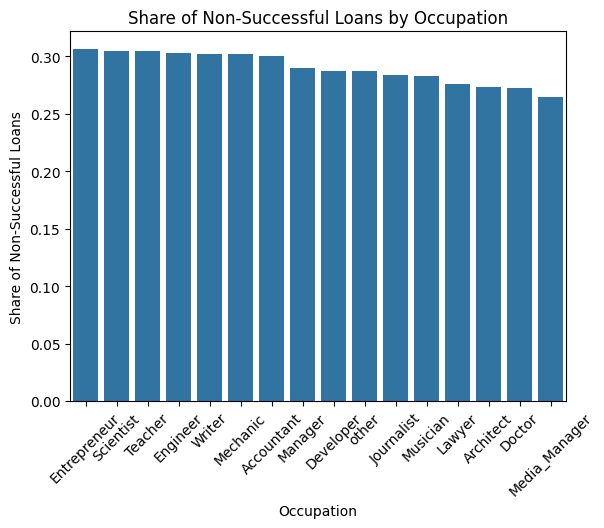

In [263]:
def seperated(x):
    if x == 'good':
        return 1
    if x == 'Poor':
        return 0
    else:
        return 2

df['Credit_Score_show'] = df['Credit_Score'].apply(lambda x: seperated(x))
non_successful_loans = df.groupby('Occupation')['Credit_Score_show'].apply(lambda x: (x == 0).mean())\
    .sort_values(ascending=False)

sns.barplot(x=non_successful_loans.index, y=non_successful_loans.values)
plt.xlabel('Occupation')
plt.ylabel('Share of Non-Successful Loans')
plt.title('Share of Non-Successful Loans by Occupation')
plt.xticks(rotation=45)
plt.show()

df.drop(columns=['Credit_Score_show'], inplace=True)

Можно заметить, что доля неудачных кредитов у <code>предпринимателей</code> больше всего. 

<Axes: xlabel='Count', ylabel='Occupation'>

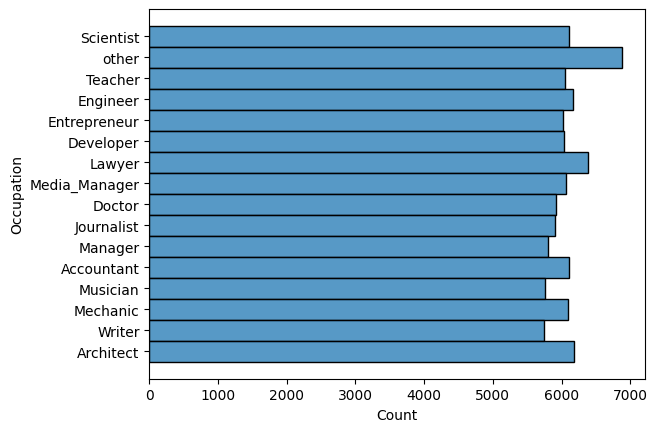

In [264]:
# посмотрим на долю пользователей из разных доменных областей
sns.histplot(df, y='Occupation')

Больше всего пользователей из неопределенной области <code>other</code>

### Annual_Income <code>+</code> Monthly_Inhand_Salary <code>--></code> Income_Stability
Заполним все пустые значения для Monthly_Inhand_Salary <code>value = Annual_Income / 12</code> и создадим новую фичу <code>Income_Stability</code>, которая показывает соотношение годового дохода к ожидаемому годовому доходу на основе ежемесячной зарплаты.

In [265]:
df['Annual_Income'].unique()
df['Annual_Income'] = df['Annual_Income'].apply(lambda x: x.replace('-','').replace('_','')).astype(float)

df["Monthly_Inhand_Salary"] = df["Monthly_Inhand_Salary"].fillna(df["Annual_Income"]/12)

df['Income_Stability'] = (df['Monthly_Inhand_Salary'] * 12) / df['Annual_Income']

df.drop(columns=['Annual_Income','Monthly_Inhand_Salary'], inplace=True)

### Total_EMI_per_month <code>+</code> Monthly_Balance <code>--></code> Expense_to_Balance_Ratio

Эта новая фича будет интерпритировать финансовое состояние клиента, сколько расходов он имеет по сравнению с его ежемесячным балансом.

In [266]:
df["Monthly_Balance"] = df["Monthly_Balance"].apply(lambda x: str(x))
df['Monthly_Balance'].replace('nan', '0', inplace=True)
df['Monthly_Balance'].replace('__-333333333333333333333333333__', '0', inplace=True)

df["Monthly_Balance"] = df["Monthly_Balance"].astype(np.float16)
df['Monthly_Balance'] = df['Monthly_Balance'].apply(lambda x: df['Monthly_Balance'].mean() if x == 0 else x)
df['Monthly_Balance'] = df['Monthly_Balance'].fillna(df['Monthly_Balance'].mean())

df['Expense_to_Balance_Ratio'] = df['Total_EMI_per_month'] / df['Monthly_Balance']

df.drop(columns=['Total_EMI_per_month', 'Monthly_Balance'], inplace=True)

# Changed_Credit_Limit <code>+</code> Num_Credit_Inquiries <code>+</code> Num_of_Loan

Обрабатываем данные и заполняем пропущенные значения с помощью KNN.

In [267]:
from sklearn.impute import KNNImputer

def knn_impute_column(df, column, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[[column]] = imputer.fit_transform(df[[column]])    
    return df

df["Changed_Credit_Limit"] = df["Changed_Credit_Limit"].str.replace("_" , "").str.replace("-" , "")
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace("_" , "").str.replace("-100" , "0").astype(np.int16)


df = knn_impute_column(df, 'Changed_Credit_Limit') 
df = knn_impute_column(df, 'Num_Credit_Inquiries')

### Num_of_Delayed_Payment <code>+</code> Payment_of_Min_Amount <code>+</code> Payment_Behaviour <code>+</code> Delay_from_due_date <code>--></code> Payment_Reliability_Score
Создадим новую фичу, которая будет интерпритировать общий показатель надежности клиента. Этот показатель будет учитывать количество просрочек, задолжностей по дням, платежное поведение и выполнение минимального платежа.

In [268]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].apply(lambda x : 'No' if x == 'NM' else x)

df["Num_of_Delayed_Payment"] = df["Num_of_Delayed_Payment"].str.replace("_" , "").str.replace("-","").replace(np.nan,'0').astype(np.int16)

df["Payment_Behaviour"] = df["Payment_Behaviour"].replace("!@9#%8" , np.nan)
df['Payment_Behaviour'] = df['Payment_Behaviour'].fillna(method='ffill')

In [269]:
def calculate_payment_reliability(df):
    score = 100  

    def payment_behaviour_score(behaviour):
        if "Irregular" in behaviour:
            return -10
        elif "Regular" in behaviour:
            return 5
        elif "High_spent" in behaviour:
            return -5
        elif "Low_spent" in behaviour:
            return 0
        else:
            return 0


    score -= df['Delay_from_due_date'].apply(lambda x: -x if x > 0 else abs(x))
    score -= df['Num_of_Delayed_Payment'] * 5    
    score += df['Payment_Behaviour'].apply(payment_behaviour_score)    
    score -= df['Payment_of_Min_Amount'].apply(lambda x: 10 if x == 'No' else 0)
    
    score = score.clip(0, 100)
    return score

df['Payment_Reliability_Score'] = calculate_payment_reliability(df)
df.drop(columns=['Delay_from_due_date', 'Num_of_Delayed_Payment', 'Payment_Behaviour', 'Payment_of_Min_Amount'], inplace=True)

# Credit_Mix

In [270]:
df["Credit_Mix"].unique()

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

In [271]:
# заменим пропуски на Unknown
df["Credit_Mix"] = df["Credit_Mix"].str.replace("_" , "Unknown")
df["Credit_Mix"].value_counts()

Credit_Mix
Standard    35517
Good        23614
Unknown     19633
Bad         18460
Name: count, dtype: int64

### Outstanding_Debt
Обработаем параметр, который указывает сумму непогашенного долга.

In [272]:
df["Outstanding_Debt"].unique()

array(['809.98', '605.03', '1303.01', ..., '3571.7_', '3571.7', '502.38'],
      dtype=object)

In [273]:
df["Outstanding_Debt"] = df["Outstanding_Debt"].str.replace("_" , "").astype(np.float16)

### Credit_History_Age
Переведем историю пользователя в числовой параметер (месяцы)

In [274]:
df['Credit_History_Age']

0         22 Years and 1 Months
1                           NaN
3         22 Years and 4 Months
4         22 Years and 5 Months
5         22 Years and 6 Months
                  ...          
99995     31 Years and 6 Months
99996     31 Years and 7 Months
99997     31 Years and 8 Months
99998     31 Years and 9 Months
99999    31 Years and 10 Months
Name: Credit_History_Age, Length: 97224, dtype: object

In [275]:
def parse_years_and_months_to_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0 
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0' 
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0  
    
df['Credit_History_Age_Months'] = df['Credit_History_Age'].apply(parse_years_and_months_to_months)
df.drop(columns=['Credit_History_Age'], inplace=True)

### Amount_invested_monthly

In [276]:
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace('__10000__', np.nan)

df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(
    lambda x: x.mode()[0] if not x.mode().empty else np.NaN)

df["Amount_invested_monthly"] = df["Amount_invested_monthly"].astype(float)

# Outlier
Удалим все числовые выбросы

In [277]:
df_num = df.select_dtypes(include='number')
outliers_indices = set()  

for column in df_num.columns:
    for i in df["Credit_Score"].unique():
        selected_i = df[df["Credit_Score"] == i]
        selected_column = selected_i[column]
        
        std = selected_column.std()
        mean = selected_column.mean()
        
        max_val = mean + (4 * std)
        min_val = mean - (4 * std)
        
        outliers = selected_column[(selected_column > max_val) | (selected_column < min_val)].index
        outliers_indices.update(outliers)

df.drop(index=outliers_indices, inplace=True)

Визуализируем распределение каждого числового признака по категориям целевой переменной

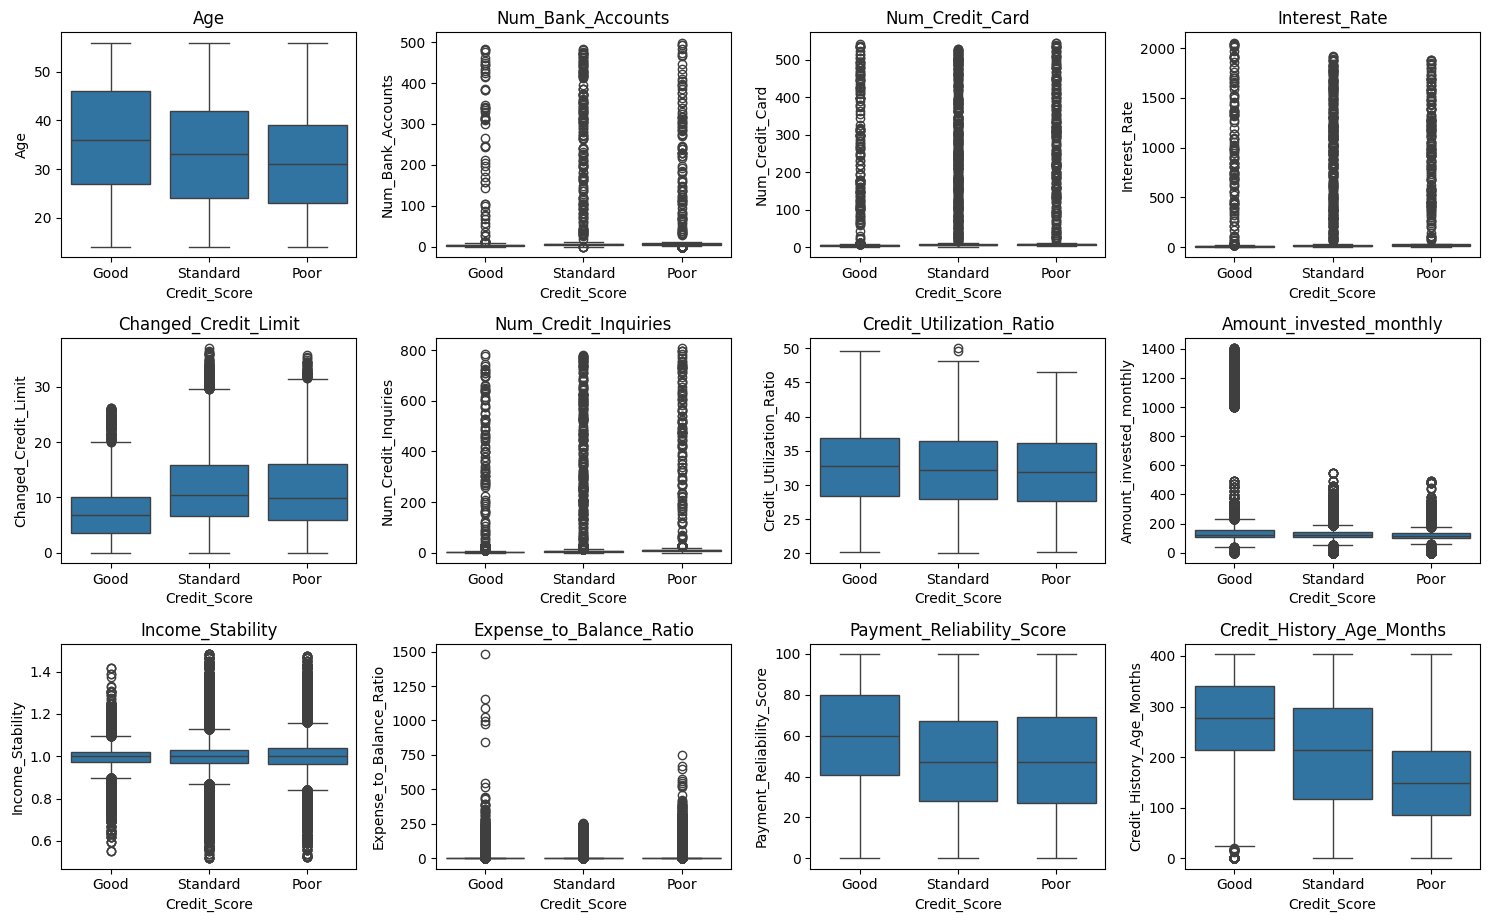

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns

df_numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

plt.figure(figsize=(15, 15))
for i, col in enumerate(df_numeric_cols):
    plt.subplot(5, 4, i + 1)  
    sns.boxplot(x='Credit_Score', y=col, data=df)
    plt.title(col) 

plt.tight_layout()
plt.show()

### Credit_Score
Создадим bar-plot для целевой переменной

In [279]:
df.Credit_Score.value_counts()

Credit_Score
Standard    46393
Poor        25979
Good        16097
Name: count, dtype: int64

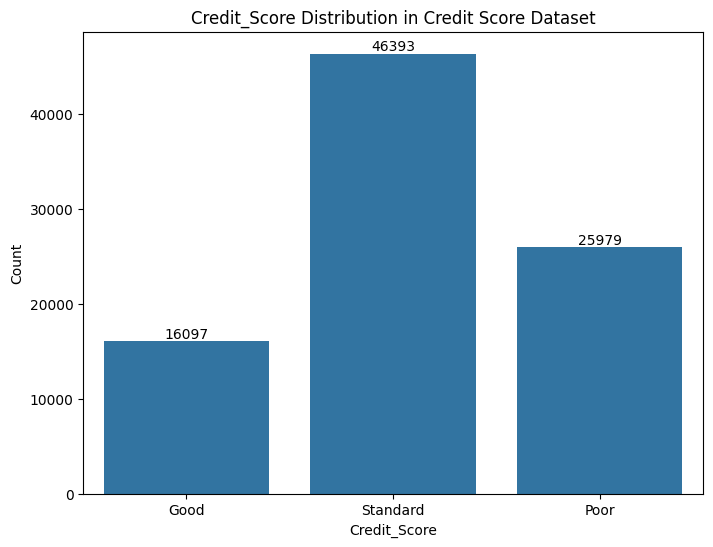

In [280]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=df, x='Credit_Score')
ax.bar_label(ax.containers[0])
plt.title('Credit_Score Distribution in Credit Score Dataset')
plt.xlabel('Credit_Score')
plt.ylabel('Count')
plt.show()

Прослеживается дисбаланс классов целевого параметра. 

### Отбросим ненужные фичи

In [281]:
df = df.drop(columns=["ID", "Customer_ID", "Name", "SSN", "Type_of_Loan", "Month"])

In [282]:
# Посмотрим наличие пустых значений в датасете 

missing_count = df.isnull().sum()
value_count = df.isnull().count()
missing_percentage = round(missing_count / value_count * 100, 2)
missing_df = pd.DataFrame({"count": missing_count, "percentage": missing_percentage})
missing_df

,count,percentage
Age,0,0.0
Occupation,0,0.0
Num_Bank_Accounts,0,0.0
Num_Credit_Card,0,0.0
Interest_Rate,0,0.0
Num_of_Loan,0,0.0
Changed_Credit_Limit,0,0.0
Num_Credit_Inquiries,0,0.0
Credit_Mix,0,0.0
Outstanding_Debt,0,0.0


## Data Processing
Будем кодировать категориальные признаки с помощью OrdinalEncoder, LabelEncoder. Не будем использовать One-HotEncoder, чтобы df не раздулся. 

In [284]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

cat_col = list(df.select_dtypes(include=['object']).columns)
print(f'Категориальные переменные: %s' % cat_col)

Категориальные переменные: ['Occupation', 'Credit_Mix', 'Credit_Score']


In [293]:
label_encoder = LabelEncoder()
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])

In [286]:
def encoder(df, column, labels):
    encoder = OrdinalEncoder(categories=[labels])
    df[column] = encoder.fit_transform(df[[column]])
    return df


labels_credit_score = ['Poor', 'Standard', 'Good']
labels_credit_mix = ['Bad', 'Standard', 'Good' , 'Unknown']

df = encoder(df, 'Credit_Mix', labels_credit_mix)
df = encoder(df, 'Credit_Score', labels_credit_score)

In [287]:
df.head()

,Age,Occupation,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Amount_invested_monthly,Credit_Score,Income_Stability,Expense_to_Balance_Ratio,Payment_Reliability_Score,Credit_History_Age_Months
0,23,12,3,4,3,4,11.27,4.0,3.0,810.0,26.822620,118.280222,2.0,1.145651,0.158640,53,265
1,23,12,3,4,3,4,11.27,4.0,2.0,810.0,31.944960,118.280222,2.0,1.000000,0.174100,89,0
3,23,12,3,4,3,4,6.27,4.0,2.0,810.0,31.377862,118.280222,2.0,1.000000,0.221812,75,268
4,23,12,3,4,3,4,11.27,4.0,2.0,810.0,24.797347,118.280222,2.0,1.145651,0.145168,91,269
5,23,12,3,4,3,4,9.27,4.0,2.0,810.0,27.262259,118.280222,2.0,1.000000,0.145595,73,270


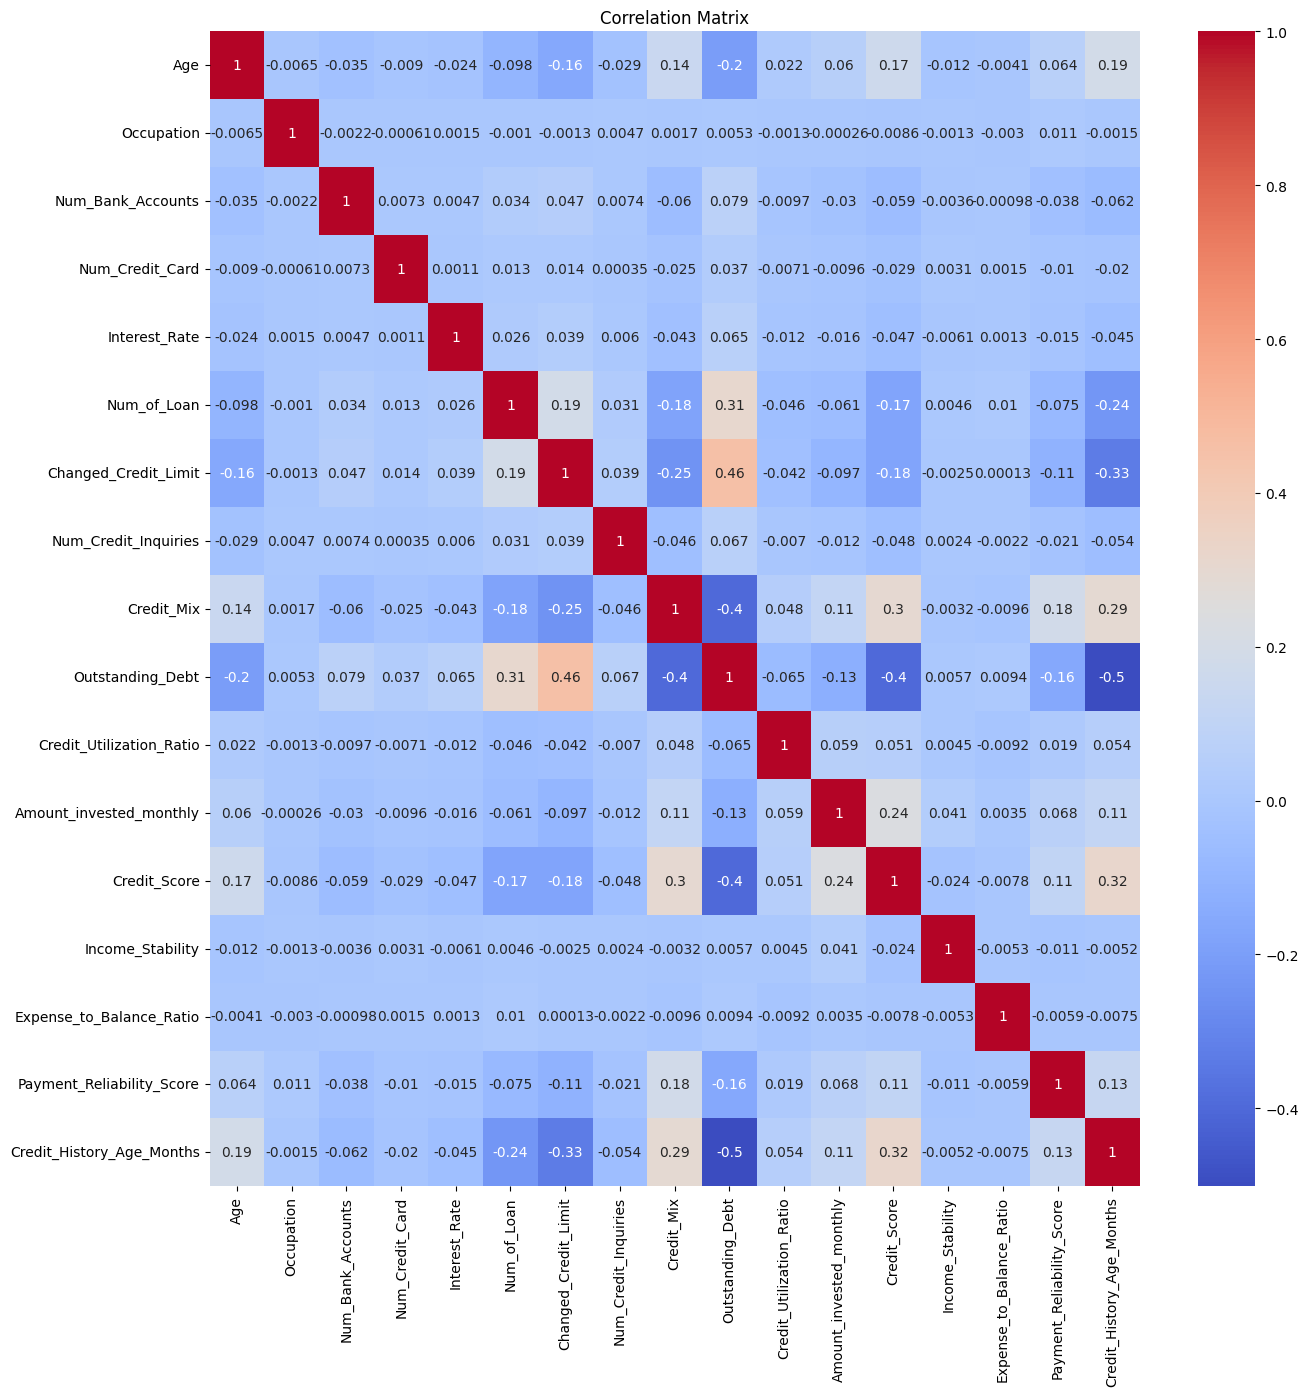

In [289]:
# построим матрицу корреляции
correlation_matrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

# Модель
Так как у нас дисбаланс классоа целевой переменной, то используем SMOTE для увеличения числа образцов меньшего класса. Для пропорциональности распределения классов будем данные стратифицировать.

In [290]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X = df.drop(['Credit_Score'], axis=1)
y = df['Credit_Score']


smote = SMOTE()
X, y = smote.fit_resample(X,y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=22, stratify=y)

In [291]:
# масштабируем данные
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [292]:
rf = RandomForestClassifier(random_state=7)
svc = SVC(random_state=7)
lr = LogisticRegression(random_state=7)

model = StackingClassifier(estimators=[('rf',rf), ('svc',svc),('lr',lr)])
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86     18557
         1.0       0.81      0.78      0.79     18558
         2.0       0.88      0.91      0.90     18557

    accuracy                           0.85     55672
   macro avg       0.85      0.85      0.85     55672
weighted avg       0.85      0.85      0.85     55672



- **Для poor**: Основной акцент на recall, чтобы модель находила как можно больше клиентов с высоким риском.
- **Для good**: Основной акцент на precision, чтобы минимизировать случаи, когда клиент ошибочно классифицируется как poor или standard.
- **Для standard**: Поддержание баланса между recall и precision, так как клиенты из этой категории считаются промежуточными по риску. (не совсем ясно что подразумевается под стандартом)

### Интерпретация результатов

Если модель показывает высокий recall для категории poor, это значит, что она успешно выявляет большинство рискованных клиентов, что важно для управления рисками в кредитном портфеле. Если recall для poor низкий, это может означать о необходимости доработки модели, чтобы сократить пропуски рискованных заемщиков.